# Run filters on the folded targets

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/projects/crispy_shifty/projects/crispy_crispies
running on node: dig72


### Set working directory to the root of the crispy_shifty repo

In [2]:
os.chdir("/projects/crispy_shifty")

### Filter the binders

In [ ]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "08_filter_again"
design_list_file = os.path.join(
    os.getcwd(), "projects/crispy_crispies/07_fold_again/folded_binders.list"
)
output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")
options = " ".join(
    [
        "out:level 300",
    ]
)

gen_array_tasks(
    distribute_func="projects.crispy_crispies.deployables.filter_binder",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="short",
    memory="4G",
    nstruct=1,
    nstruct_per_task=100,
    options=options,
    simulation_name=simulation_name,
)

### Collect scorefiles of the filtered binders

In [3]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "08_filter_again"
output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html
https://conda.io/activation



### Load resulting concatenated scorefile

In [4]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

### Dump scores_df as a CSV and then reload, for performance reasons

In [5]:
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

### Setup for plotting

In [6]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration

In [7]:
print(len(scores_df))
print(list(scores_df.columns))

870075
['bb_clash', 'bb_clash_delta', 'best_average_DAN_plddts', 'best_average_plddts', 'best_model', 'best_ptm', 'best_rmsd_to_input', 'buns_parent', 'chA_seq', 'cms', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'count_apolar', 'ddg', 'designed_by', 'docked_helix', 'dslf_fa13', 'dssp', 'elapsed_time', 'exposed_hydrophobics_parent', 'fa_atr', 'fa_dun', 'fa_elec', 'fa_intra_rep', 'fa_intra_sol_xover4', 'fa_rep', 'fa_sol', 'geometry_parent', 'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb', 'holes_all_parent', 'holes_core_parent', 'insertion_dG', 'kept_end', 'kept_start', 'lk_ball_wtd', 'loop_dist', 'loop_sc', 'looped_length', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'model', 'mpnn_design_area', 'mpnn_temperature', 'new_loop_str', 'omega', 'pTMscore', 'p_aa_pp', 'packstat_parent', 'parent', 'parent_length', 'pa

### Get a set to order that are really good for Secretin

In [8]:
to_order = scores_df.query(
    "target_name == 'Secretin' and ddg < -50 and insertion_dG > 3.5 and cms > 500 and mean_pae_intra_chain_A < 2.5"
)
len(to_order)

66

### Dump a list of the order

In [9]:
with open(os.path.join(output_path, "sec.list"), "a") as f:
    for decoy in to_order.index:
        print(decoy, file=f)

### Add ID column

In [11]:
ids = [f"sec_{str(i).zfill(3)}" for i in range(1, 66 + 1)]
to_order["id"] = ids
to_order["id"]

/scratch/pleung/4128329/ipykernel_170908/676079128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_order["id"] = ids


/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0152/08_filter_again_381e8ddf77d64f2ca882c92f2d3b8f57.pdb.bz2    sec_001
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0766/08_filter_again_f9b7eb08d3dd453592300ba870a333a9.pdb.bz2    sec_002
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0089/08_filter_again_1f0bf185648641fbbc662ea84ecf6ead.pdb.bz2    sec_003
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0160/08_filter_again_f0d2547985064c60bfb86938307e6ac5.pdb.bz2    sec_004
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0083/08_filter_again_cdfd2830a3f444ac91cd65906b791f84.pdb.bz2    sec_005
                                                                                                                                              ...   
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0134/08_filter_again_6c31c281a

### Dump PDBs and FASTAs

In [12]:
import shutil

simulation_name = "08_filter_again"
output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")
pdbs_path = os.path.join(output_path, "pdbs")
os.makedirs(pdbs_path, exist_ok=True)
with open(os.path.join(output_path, "20221005_order.fasta"), "w") as f:
    for i, r in tqdm(to_order.iterrows(), total=to_order.shape[0]):
        print(f">{r.id}", file=f)
        print(f"{r.chA_seq}", file=f)
        shutil.copy(i, os.path.join(pdbs_path, f"{r.id}.pdb.bz2"))

  0%|          | 0/66 [00:00<?, ?it/s]

### Label binders that worked

In [9]:
worked = [
    "/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0766/08_filter_again_f9b7eb08d3dd453592300ba870a333a9.pdb.bz2",
    "/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0817/08_filter_again_b67b3065507b46cfa6a2e75de096ce83.pdb.bz2",
    "/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0833/08_filter_again_11dff12291f7425cbb1d39a3626a93c5.pdb.bz2",
    "/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0722/08_filter_again_6fec94b8006a4059a171889a382d7a6a.pdb.bz2",
]

good = to_order.loc[worked]
bad = pd.merge(to_order, good, how="outer", indicator=True)
bad = bad[bad._merge == "left_only"].drop("_merge", axis=1)
good["worked"] = True
bad["worked"] = False
sample_df = pd.concat([good, bad])

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [10]:
from crispy_shifty.protocols.design import beta_nov16_terms

sample_df = sample_df[
    [term for term in sample_df.columns if term not in beta_nov16_terms]
]
print(len(sample_df))
print(list(sample_df.columns))

66
['bb_clash', 'bb_clash_delta', 'best_average_DAN_plddts', 'best_average_plddts', 'best_model', 'best_ptm', 'best_rmsd_to_input', 'buns_parent', 'chA_seq', 'cms', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'count_apolar', 'ddg', 'designed_by', 'docked_helix', 'dssp', 'elapsed_time', 'exposed_hydrophobics_parent', 'geometry_parent', 'holes_all_parent', 'holes_core_parent', 'insertion_dG', 'kept_end', 'kept_start', 'loop_dist', 'loop_sc', 'looped_length', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'model', 'mpnn_design_area', 'mpnn_temperature', 'new_loop_str', 'pTMscore', 'packstat_parent', 'parent', 'parent_length', 'path_in', 'pdb', 'pivot_helix', 'pre_break_helix', 'prefix', 'recycles', 'rmsd_to_reference', 'sap_parent', 'sc_AcB', 'sc_AnAc', 'sc_AnAcB', 'sc_AnB', 'sc_all_parent', 'scaffold_type', 'score', 'score_

In [11]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

### Plot before and after interface design AF2 metrics

23it [00:01, 19.18it/s]


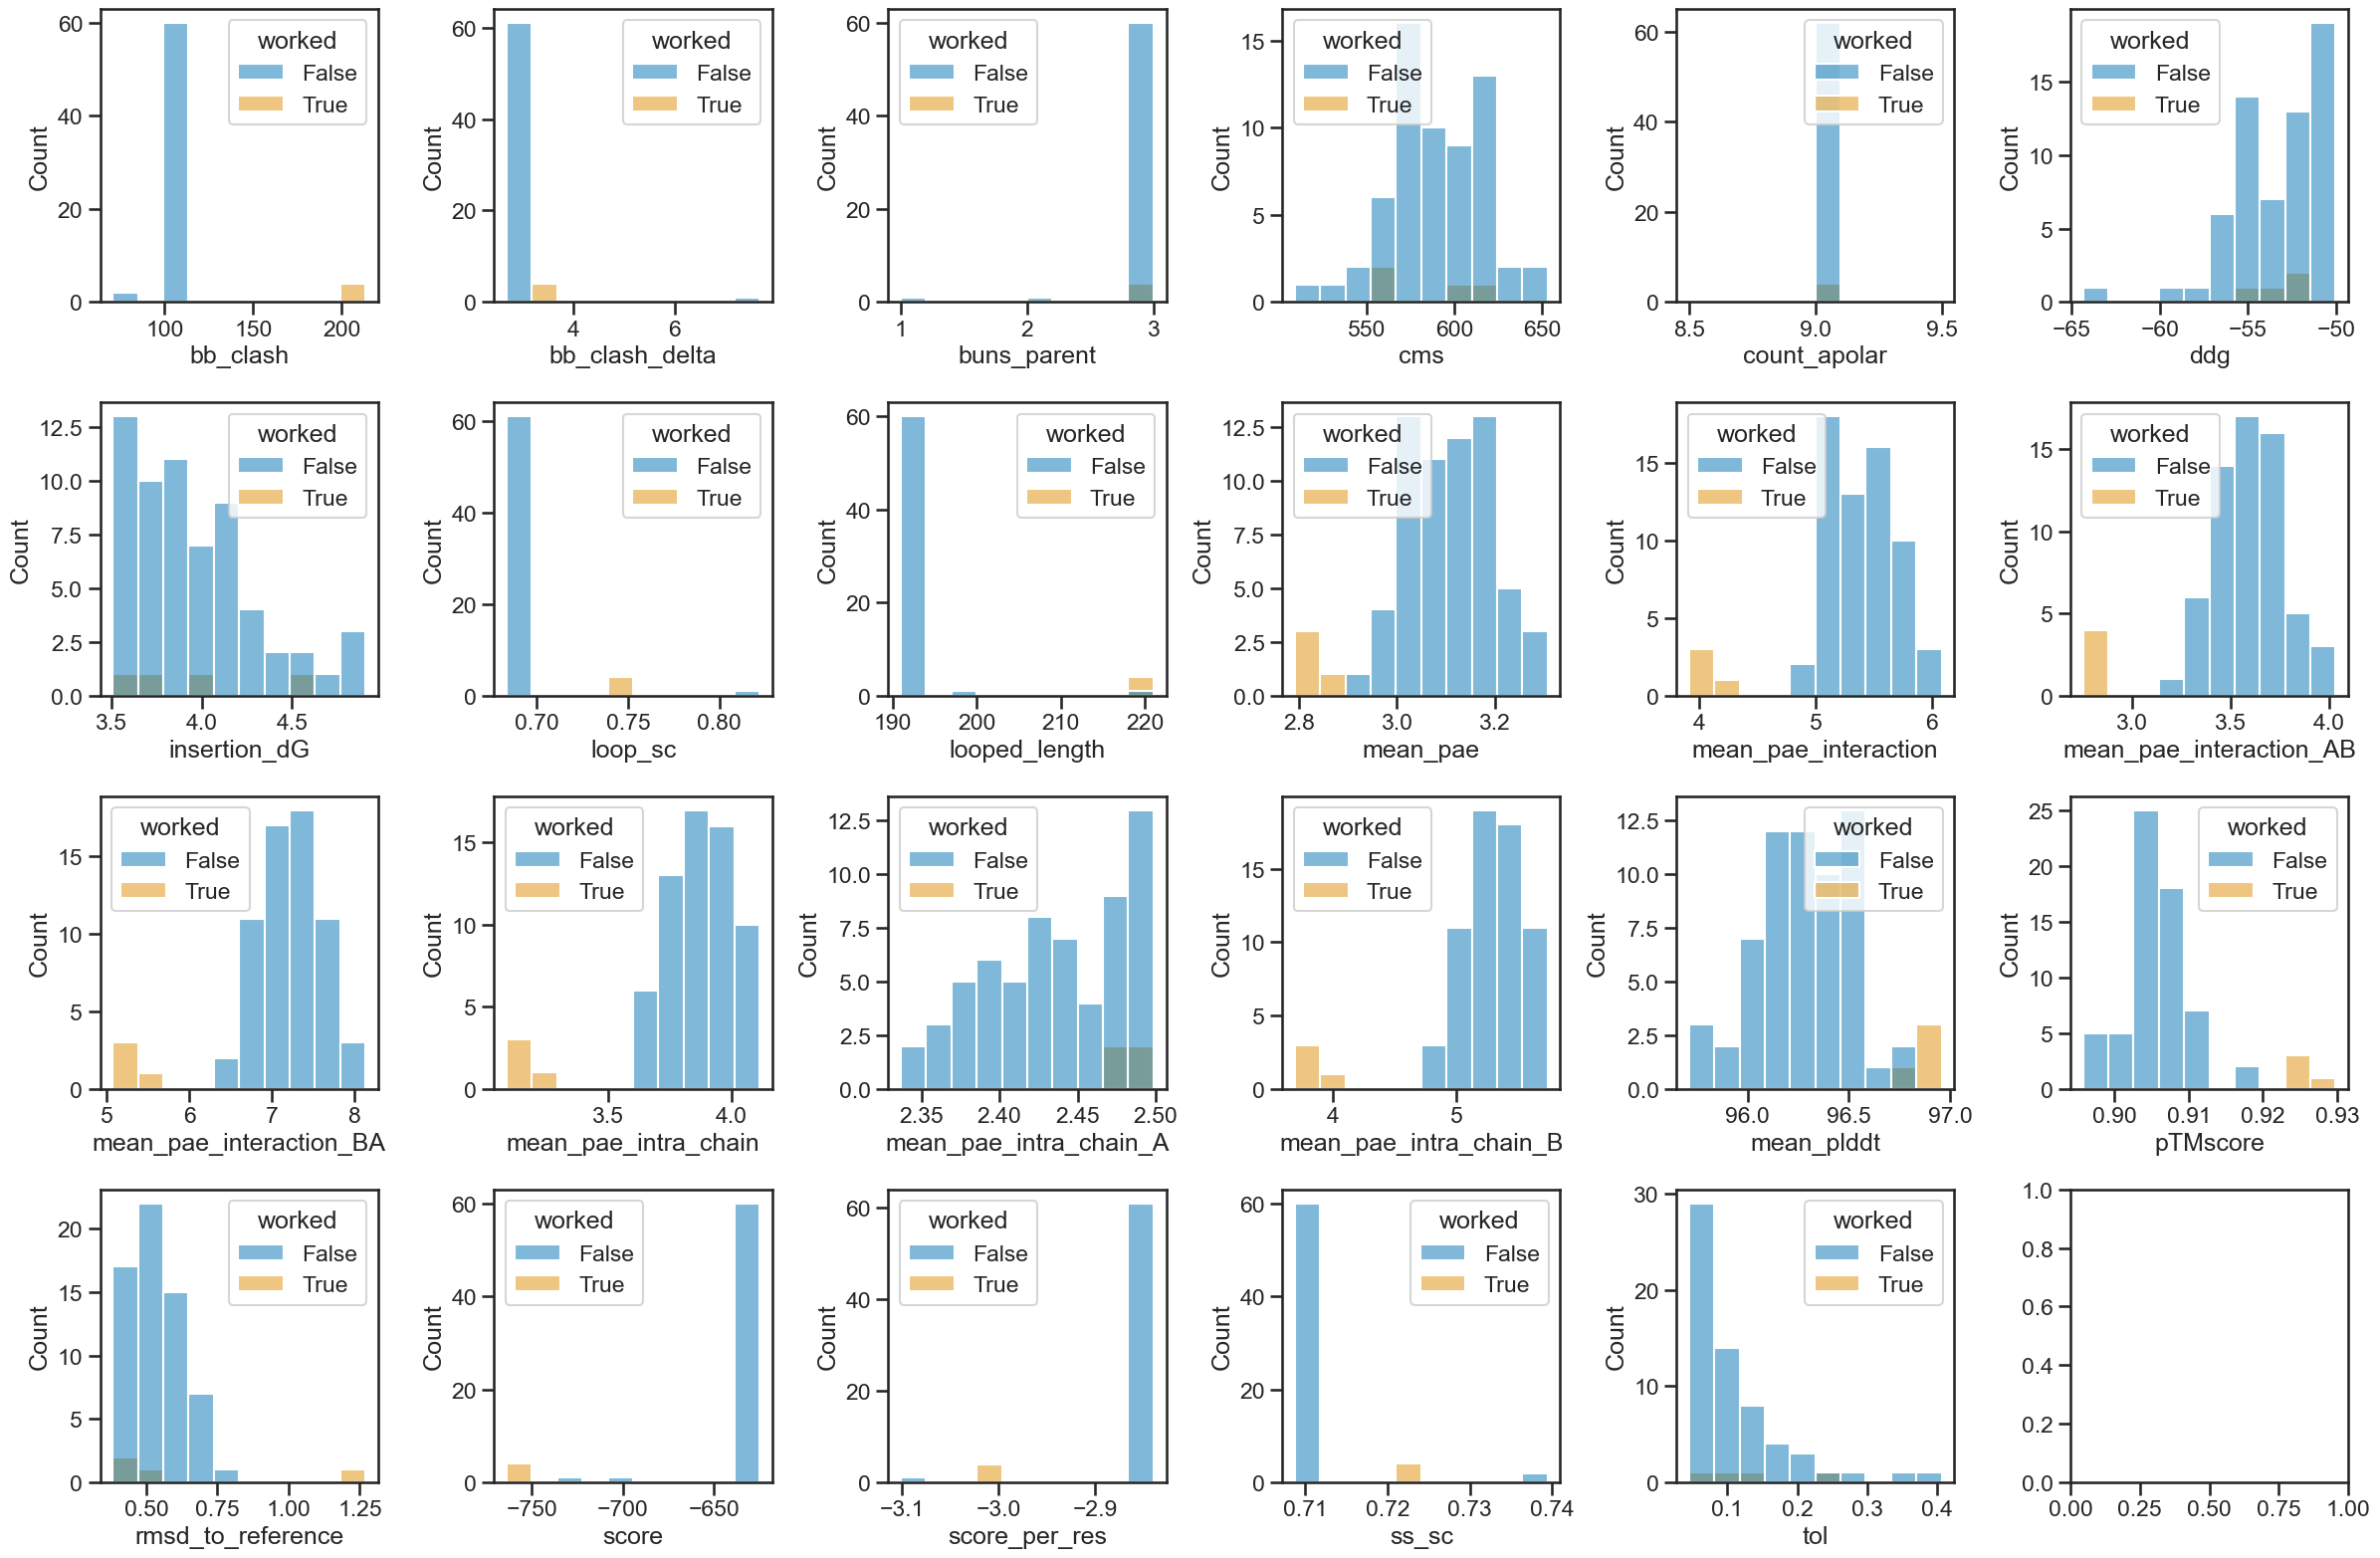

In [12]:
cols = [
    "bb_clash",
    "bb_clash_delta",
    "buns_parent",
    "cms",
    "count_apolar",
    "ddg",
    "insertion_dG",
    "loop_sc",
    "looped_length",
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_interaction_AB",
    "mean_pae_interaction_BA",
    "mean_pae_intra_chain",
    "mean_pae_intra_chain_A",
    "mean_pae_intra_chain_B",
    "mean_plddt",
    "pTMscore",
    "rmsd_to_reference",
    "score",
    "score_per_res",
    "ss_sc",
    "tol",
]

the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="worked",
)
plt.savefig(os.path.join(output_path, "metrics.png"))

In [13]:
scores_df.groupby("target_name").count()

,bb_clash,bb_clash_delta,best_average_DAN_plddts,best_average_plddts,best_model,best_ptm,best_rmsd_to_input,buns_parent,chA_seq,cms,...,target_seq,threaded_seq,time,tol,topo,total_length,total_score,trimmed_length,type,yhh_planarity
target_name,,,,,,,,,,,,,,,,,,,,,
APOE,208731,208731,208731,208731,208731,208731,208731,208731,208731,208731,...,208731,208731,208731,208731,208731,208731,208731,208731,208731,208731
GIP,28443,28443,28443,28443,28443,28443,28443,28443,28443,28443,...,28443,28443,28443,28443,28443,28443,28443,28443,28443,28443
GLP1,5144,5144,5144,5144,5144,5144,5144,5144,5144,5144,...,5144,5144,5144,5144,5144,5144,5144,5144,5144,5144
GLP2,114978,114978,114978,114978,114978,114978,114978,114978,114978,114978,...,114978,114978,114978,114978,114978,114978,114978,114978,114978,114978
Glicentin,4073,4073,4073,4073,4073,4073,4073,4073,4073,4073,...,4073,4073,4073,4073,4073,4073,4073,4073,4073,4073
Glucagon,2193,2193,2193,2193,2193,2193,2193,2193,2193,2193,...,2193,2193,2193,2193,2193,2193,2193,2193,2193,2193
NPY_9-35,140183,140183,140183,140183,140183,140183,140183,140183,140183,140183,...,140183,140183,140183,140183,140183,140183,140183,140183,140183,140183
PTH,53126,53126,53126,53126,53126,53126,53126,53126,53126,53126,...,53126,53126,53126,53126,53126,53126,53126,53126,53126,53126
Secretin,313204,313204,313204,313204,313204,313204,313204,313204,313204,313204,...,313204,313204,313204,313204,313204,313204,313204,313204,313204,313204


### Get a set to order that are really good for GIP

In [18]:
to_order = scores_df.query(
    "target_name == 'GIP' and ddg < -50 and insertion_dG > 3 and cms > 500 and mean_pae_intra_chain_A < 3.5  and mean_pae_interaction < 6.8"
)
len(to_order)

12

### Dump a list of the order

In [19]:
with open(os.path.join(output_path, "gip.list"), "w") as f:
    for decoy in to_order.index:
        print(decoy, file=f)

### Add ID column

In [20]:
ids = [f"gip_{str(i).zfill(3)}" for i in range(1, len(to_order) + 1)]
to_order["id"] = ids
to_order["id"]

/scratch/pleung/15510482/ipykernel_2260296/3893621664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_order["id"] = ids


/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0578/08_filter_again_5e1f1b1dbc484aee865d766bc757f9c8.pdb.bz2    gip_001
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0779/08_filter_again_5173298fb0f8473eaf8bedf2d09cc1ff.pdb.bz2    gip_002
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0249/08_filter_again_47fca223d0664aa2b23c20fc71614cd0.pdb.bz2    gip_003
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0731/08_filter_again_93c48fabe7d646918f3a3bc9cdff3c95.pdb.bz2    gip_004
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0664/08_filter_again_5de4f6eaa4d547789e93efc121c6fa91.pdb.bz2    gip_005
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0799/08_filter_again_908c37ccb6d84b6cb58828809cb38771.pdb.bz2    gip_006
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0143/08_filter_again_1eb94c148

### Dump PDBs and FASTAs

In [21]:
import shutil

simulation_name = "08_filter_again"
output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")
pdbs_path = os.path.join(output_path, "pdbs")
os.makedirs(pdbs_path, exist_ok=True)
with open(os.path.join(output_path, "20221128_order.fasta"), "w") as f:
    for i, r in tqdm(to_order.iterrows(), total=to_order.shape[0]):
        print(f">{r.id}", file=f)
        print(f"{r.chA_seq}", file=f)
        shutil.copy(i, os.path.join(pdbs_path, f"{r.id}.pdb.bz2"))

  0%|          | 0/12 [00:00<?, ?it/s]

### Get a set to order that are really good for GLP1

In [25]:
to_order = scores_df.query(
    "target_name == 'GLP1' and ddg < -45 and insertion_dG > 3 and cms > 450 and mean_pae_interaction < 7"
)
len(to_order)

6

### Dump a list of the order

In [26]:
with open(os.path.join(output_path, "glp1.list"), "w") as f:
    for decoy in to_order.index:
        print(decoy, file=f)

### Add ID column

In [27]:
ids = [f"glp1_{str(i).zfill(3)}" for i in range(1, len(to_order) + 1)]
to_order["id"] = ids
to_order["id"]

/scratch/pleung/15510482/ipykernel_2260296/207964872.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_order["id"] = ids


/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0394/08_filter_again_e6b39bd5ed4c48febe7dd79c928e77d0.pdb.bz2    glp1_001
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0466/08_filter_again_b2f659fbecf14e589e44b4d3dd25578f.pdb.bz2    glp1_002
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0440/08_filter_again_e37849eeff99476a93f0e97d3b10e91e.pdb.bz2    glp1_003
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0274/08_filter_again_d2926857474547bfaecdf7d1f35f1f06.pdb.bz2    glp1_004
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0451/08_filter_again_71839a5d5b9a4edaa878fb75b743e1e9.pdb.bz2    glp1_005
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0536/08_filter_again_9f43665656104da4a3e73d223297a4a8.pdb.bz2    glp1_006
Name: id, dtype: object

### Dump PDBs and FASTAs

In [28]:
import shutil

simulation_name = "08_filter_again"
output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")
pdbs_path = os.path.join(output_path, "pdbs")
os.makedirs(pdbs_path, exist_ok=True)
with open(os.path.join(output_path, "20221128_order.fasta"), "a") as f:
    for i, r in tqdm(to_order.iterrows(), total=to_order.shape[0]):
        print(f">{r.id}", file=f)
        print(f"{r.chA_seq}", file=f)
        shutil.copy(i, os.path.join(pdbs_path, f"{r.id}.pdb.bz2"))

  0%|          | 0/6 [00:00<?, ?it/s]

### Get a set to order that are really good for GLP2

In [33]:
to_order = scores_df.query(
    "target_name == 'GLP2' and ddg < -50 and insertion_dG > 3 and cms > 500 and mean_pae_intra_chain_A < 3.5 and mean_pae_interaction < 4.1"
)
len(to_order)

36

### Dump a list of the order

In [34]:
with open(os.path.join(output_path, "glp2.list"), "a") as f:
    for decoy in to_order.index:
        print(decoy, file=f)

### Add ID column

In [35]:
ids = [f"glp2_{str(i).zfill(3)}" for i in range(1, len(to_order) + 1)]
to_order["id"] = ids
to_order["id"]

/scratch/pleung/15456162/ipykernel_1791935/3053248131.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_order["id"] = ids


/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0465/08_filter_again_a00eee2865964e34b77c63a94b51d662.pdb.bz2    glp2_001
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0251/08_filter_again_00c9a8f01025495ca006570630da8897.pdb.bz2    glp2_002
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0364/08_filter_again_1755d094419c4362b56947743dc4717d.pdb.bz2    glp2_003
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0136/08_filter_again_584d6ce8520345338bc92bffe83727f2.pdb.bz2    glp2_004
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0444/08_filter_again_8210f7d5d8b74386ab70107f815c9e43.pdb.bz2    glp2_005
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0300/08_filter_again_ab7b7f03ddb84834a9fe93399e994c86.pdb.bz2    glp2_006
/mnt/projects/crispy_shifty/projects/crispy_crispies/08_filter_again/decoys/0394/08_filter_again_7a3

### Dump PDBs and FASTAs

In [36]:
import shutil

simulation_name = "08_filter_again"
output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")
pdbs_path = os.path.join(output_path, "pdbs")
os.makedirs(pdbs_path, exist_ok=True)
with open(os.path.join(output_path, "20221128_order.fasta"), "a") as f:
    for i, r in tqdm(to_order.iterrows(), total=to_order.shape[0]):
        print(f">{r.id}", file=f)
        print(f"{r.chA_seq}", file=f)
        shutil.copy(i, os.path.join(pdbs_path, f"{r.id}.pdb.bz2"))

  0%|          | 0/36 [00:00<?, ?it/s]